# 6 Degrees of Kevin Bacon

This project will look at the Ranker website for Cast Lists of Every Film to Devlop a Tool for playing the popular Game for 6 degrees of Kevin Bacon.  It will also be evaluated if Kevin Bacon really is the most connected celebrity, or if other celebirties are more connected

In [1]:
from bs4 import BeautifulSoup
import re
import requests
from requests_futures.sessions import FuturesSession
from string import ascii_lowercase
import string

## Get the cast list for each movie

### Get the links for all the movie pages

In [2]:
#compile regular expression to remove full cast of actors and actresses
title_clean=re.compile('(Full Cast of|Actors/Actresses|-\sCast/Actors in This Movie)')

from string import ascii_lowercase
movie_list=[]
for letter in ascii_lowercase:
    link_page='https://www.ranker.com/fact-lists/film-actors/films/'+letter
    page=requests.get(link_page)
    soup=BeautifulSoup(page.text)
    movies=soup.select('div.catgListing li > a')
    movie_list.extend([tuple([title_clean.sub('',m.text).strip(),m['href']]) for m in movies])

/opt/conda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


### Pull the cast list from each page

In [3]:
#function for getting the list of actors off a page
def get_cast_list(page):    
    soup=BeautifulSoup(page.text)
    items=soup.select('div.listItem__data a')
    return [actor.text for actor in items]

In [4]:
from ediblepickle import checkpoint

@checkpoint(key=string.Template('RankerMovie{0}.pkd'))
def cached_page_retrieval(movie,link):
    return requests.get(link)

url='https://www.ranker.com'

cast_lists=[]
for m in movie_list:
    try:
        page=cached_page_retrieval(m[0].replace('/',''),url+m[1])
    except Exception:
        page=requests.get(url+m[1])
    cast_list=get_cast_list(page)
    cast_lists.extend([tuple([m[0],cast_list])])

## Analyze the Data

### Make a graph of actors who have been in movies together

In [5]:
import itertools
import networkx as nx

G=nx.Graph()
for movie in cast_lists:
    if len(movie)>1:
        for pair in  itertools.combinations(movie[1],2):
            G.add_edge(pair[0],pair[1], name=movie[0])

In [6]:
G.degree(['Kevin Bacon'])

{'Kevin Bacon': 539}

### Determine the most conected actors using "Degree"

In [9]:
from heapq import heappush, heappop

degree_heap=[]
for person in G.nodes_iter():
    degree_tuple=tuple([-1*G.degree([person]).values()[0],person])
    heappush(degree_heap,degree_tuple)

#copy the degree heap so it can be popped multiple times
degree_heap2=list(degree_heap)

most_connections=[]
for _ in xrange(100):
    person=heappop(degree_heap)
    most_connections.append(tuple([person[1],-1*person[0]]))   
print(most_connections[0:10])

actor=''


[(u'Samuel L. Jackson', 1034), (u'Anupam Kher', 705), (u'Keith David', 682), (u'Shakti Kapoor', 678), (u'Robert De Niro', 674), (u'Bruce Willis', 670), (u'Donald Sutherland', 638), (u'Asrani', 634), (u'Christopher Walken', 628), (u'Tom Cruise', 616)]


It turns out the Kevin Bacon is not one of the 10 Actors with the highers degrees.

**Lets see how far down he actually ranks**

In [8]:
while actor!=u'Kevin Bacon':
    count+=1
    actor=heappop(degree_heap2)[1]
print('Kevin Bacon is the %d most connected actor'%count)

Kevin Bacon is the 31 most connected actor


### Look at pagerank to see if the mystique of Kevin Bacon is that his connections have a lot of connections

In [10]:
pr=nx.pagerank(G)

In [11]:
pr_heap=[]
for person in pr.iteritems():
    pr_tuple=tuple([-1*person[1],person[0]])
    heappush(pr_heap,pr_tuple)

pr_heap2=list(pr_heap)
most_pr=[]
for _ in xrange(100):
    person=heappop(pr_heap)
    most_pr.append(tuple([person[1],-1*person[0]]))   
print(most_pr[0:10])

[(u'Samuel L. Jackson', 0.0004644314238820777), (u'Keith David', 0.000321011281122411), (u'Robert De Niro', 0.00030693237246395393), (u'Donald Sutherland', 0.0003006170369563207), (u'Bruce Willis', 0.0002983770741671947), (u'Anupam Kher', 0.0002955226698068339), (u'Christopher Walken', 0.000288530891591078), (u'Sean Connery', 0.00028031042971549526), (u'Tom Cruise', 0.0002796625719341551), (u'Robbie Coltrane', 0.0002743815769041216)]


The pagerank order looks pretty similar to the degree order, witht he exception that the Indian sounding names (likely Bollywood actors are lower on the list.  This makes sense as there is a larger pool of Hollywood movies then Bollywood movies.  

**Lets see how low Kevin Bacon is:**

In [12]:
while actor!=u'Kevin Bacon':
    count+=1
    actor=heappop(pr_heap2)[1]
print('Kevin Bacon is the %d most connected actor'%count)

Kevin Bacon is the 57 most connected actor


Turns out if you want to make the Six degrees game easy you should be using **Samuel L. Jackson**...

Lets see how the degrees of seperation compare between Samuel L. Jackson and Kevin Bacon


In [13]:
kb_hist=nx.shortest_path(G,target='Kevin Bacon')
slj_hist=nx.shortest_path(G,target='Samuel L. Jackson')

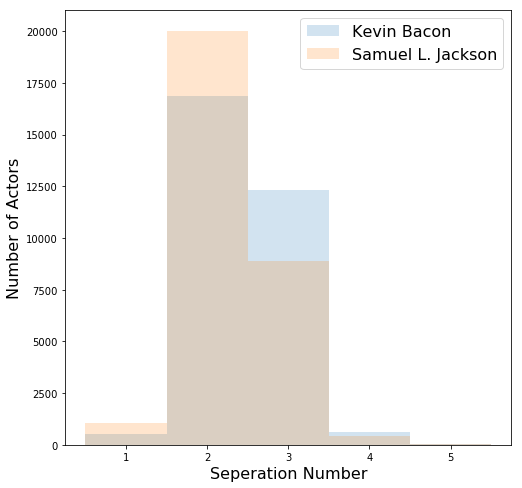

In [15]:
import matplotlib.pyplot as plt
kb_paths=[]
for a in kb_hist.items():
    kb_paths.append(len(a[1])-1)
slj_paths=[]
for a in slj_hist.items():
    slj_paths.append(len(a[1])-1)

fig=plt.figure(figsize=(8,8)) 
plt.hist(kb_paths,bins=[.5,1.5,2.5,3.5,4.5,5.5],alpha=.2,label='Kevin Bacon')
plt.hist(slj_paths,bins=[.5,1.5,2.5,3.5,4.5,5.5],alpha=.2, label='Samuel L. Jackson')
plt.legend(fontsize=16)
plt.xlabel('Seperation Number', fontsize=16)
plt.ylabel('Number of Actors', fontsize=16)
plt.show()

## Develop a function for finding the shortest path between two actors/actresses

In [16]:
def path_search(G,s,t):
    sp=nx.shortest_path(G,source=s,target=t)
    name_previous=s
    path_list=[]
    for actor in sp[1:]:
        name_tuple=tuple([actor,G[name_previous][actor]['name']])
        name_previous=actor
        path_list.append(name_tuple)
    return path_list

print(path_search(G,'Judi Dench','Grace Kelly'))

[(u'Keith David', u'The Chronicles Of Riddick'), (u'Ian MacDonald', u'Road House'), ('Grace Kelly', u'High Noon')]


It turns out there are 3 degrees of seperation between Dame Judi Dench and Princess Grace Kelly